# Convert and Optimize YOLOv8 instance segmentation model with OpenVINO™

Instance segmentation goes a step further than object detection and involves identifying individual objects in an image and segmenting them from the rest of the image. Instance segmentation as an object detection are often used as key components in computer vision systems. 
Applications that use real-time instance segmentation models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLOv8 with OpenVINO. We consider the steps required for instance segmentation scenario.

The tutorial consists of the following steps:
- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Validate the converted model.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.
- Live demo


#### Table of contents:

- [Get PyTorch model](#Get-PyTorch-model)
    - [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Verify model inference](#Verify-model-inference)
    - [Preprocessing](#Preprocessing)
    - [Postprocessing](#Postprocessing)
    - [Select inference device](#Select-inference-device)
    - [Test on single image](#Test-on-single-image)
- [Check model accuracy on the dataset](#Check-model-accuracy-on-the-dataset)
    - [Download the validation dataset](#Download-the-validation-dataset)
    - [Define validation function](#Define-validation-function)
    - [Configure Validator helper and create DataLoader](#Configure-Validator-helper-and-create-DataLoader)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Validate Quantized model inference](#Validate-Quantized-model-inference)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Compare performance of the Original and Quantized Models](#Compare-performance-of-the-Original-and-Quantized-Models)
    - [Validate quantized model accuracy](#Validate-quantized-model-accuracy)
- [Other ways to optimize model](#Other-ways-to-optimize-model)
- [Live demo](#Live-demo)
    - [Run Live Object Detection and Segmentation](#Run-Live-Object-Detection-and-Segmentation)



## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [1]:
%pip install -q "openvino" "nncf"
%pip install -q "torch" "torchvision" "ultralytics" onnx --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [1]:
from pathlib import Path

# Fetch the notebook utils script from the openvino_notebooks repo
# import urllib.request
# urllib.request.urlretrieve(
#     url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
#     filename='notebook_utils.py'
# )

from notebook_utils import download_file, VideoPlayer

Define utility functions for drawing results

In [3]:
from typing import Tuple, Dict
import cv2
import numpy as np
from PIL import Image
from ultralytics.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        
    """
    boxes = results["det"]
    masks = results.get("segment")
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

In [2]:
# Download a test sample
IMAGE_PATH = Path('./data/d3f34243-a7166713.jpg')

## Instantiate model
[back to top ⬆️](#Table-of-contents:)

For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model and boxes and masks for segmentation model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [4]:
models_dir = Path('./models')
models_dir.mkdir(exist_ok=True)


image 1/1 /Volumes/AI/adas/adas-flask/notebooks/data/d3f34243-a7166713.jpg: 384x640 1 0, 2 1s, 417.0ms
Speed: 30.2ms preprocess, 417.0ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


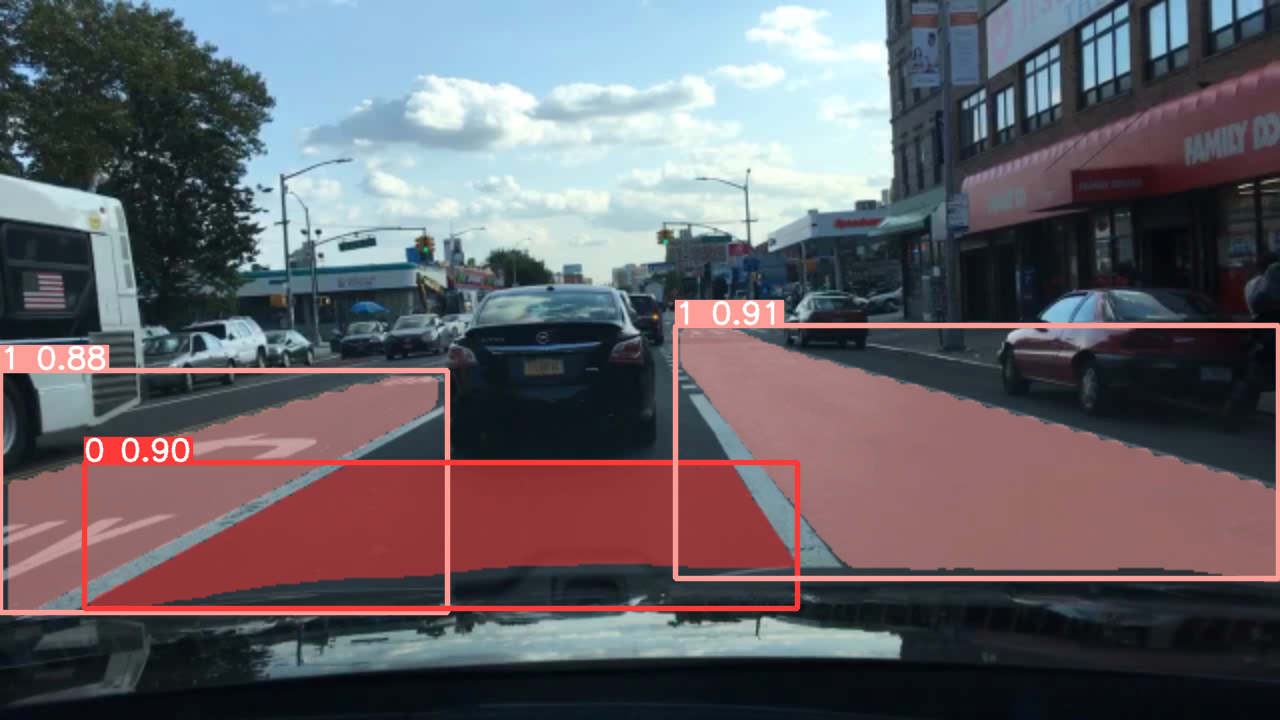

In [5]:
from ultralytics import YOLO

SEG_MODEL_NAME = "best"

seg_model = YOLO(models_dir / f'{SEG_MODEL_NAME}.pt')
label_map = seg_model.model.names

res = seg_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [6]:
# instance segmentation model
seg_model_path = models_dir / f"{SEG_MODEL_NAME}_openvino_model/{SEG_MODEL_NAME}.xml"
if not seg_model_path.exists():
    seg_model.export(format="openvino", dynamic=True, half=False)

### Verify model inference
[back to top ⬆️](#Table-of-contents:)

To test model work, we create inference pipeline similar to `model.predict` method. The pipeline consists of preprocessing step, inference of OpenVINO model and results post-processing to get results.

### Preprocessing
[back to top ⬆️](#Table-of-contents:)

Model input is a tensor with the `[-1, 3, -1, -1]` shape in the `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

The model expects images in RGB channels format and normalized in [0, 1] range. Although the model supports dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes, for example, 640x640 for better efficiency. To resize images to fit model size `letterbox`, resize approach is used, where the aspect ratio of width and height is preserved.

To keep a specific shape, preprocessing automatically enables padding.

In [7]:
from typing import Tuple
from ultralytics.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (720, 1280), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

### Postprocessing
[back to top ⬆️](#Table-of-contents:)

The model output contains:
- detection boxes candidates
- proto mask candidates

Detection boxes candidates are the tensors with the `[-1,84,-1]` shape in the `B,84,N` format, where:

- `B` - batch size
- `N` - number of detection boxes

For getting the final prediction, we need to apply a non-maximum suppression algorithm and rescale box coordinates to the original image size.

After final prediction detection box has the [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`] format, where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of the box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.


Proto mask candidates are used for instance segmentation. It should be decoded by using box coordinates. It is a tensor with the `[-1 32, -1, -1]` shape in the `B,C H,W` format, where:
- `B` - batch size
- `C` - number of candidates
- `H` - mask height
- `W` - mask width

In [8]:
try:
    scale_segments = ops.scale_segments
except AttributeError:
    scale_segments = ops.scale_coords

def postprocess(
    pred_boxes:np.ndarray, 
    input_hw:Tuple[int, int], 
    orig_img:np.ndarray, 
    min_conf_threshold:float = 0.25, 
    nms_iou_threshold:float = 0.7, 
    agnosting_nms:bool = False, 
    max_detections:int = 3,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and
                                           segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=80,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [16]:
%pip install -q "ipywidgets"

Note: you may need to restart the kernel to use updated packages.


In [9]:
import ipywidgets as widgets
import openvino as ov 

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Test on single image
[back to top ⬆️](#Table-of-contents:)

Now, once we have defined preprocessing and postprocessing steps, we are ready to check model prediction.

In [10]:
core = ov.Core()
seg_ov_model = core.read_model(seg_model_path)
if device.value != "CPU":
    seg_ov_model.reshape({0: [1, 3, 720, 720]})
seg_compiled_model = core.compile_model(seg_ov_model, device.value)


def detect(image:np.ndarray, model:ov.Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections

input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, seg_compiled_model)[0]
image_with_masks = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_masks)

RuntimeError: Exception from src/inference/src/infer_request.cpp:231:
Exception from src/plugins/intel_cpu/src/node.cpp:1660:
Shape inference of Concat node with name /model.11/Concat failed: Check 'TRShape::merge_into(output_shape, in_copy)' failed at src/core/shape_inference/include/concat_shape_inference.hpp:49:
While validating node 'opset1::Concat /model.11/Concat (/model.10/Resize[0]:f32[?,256,2..,2..], /model.6/cv2/act/Mul[0]:f32[?,128,1..,1..]) -> (f32[?,384,2..,2..])' with friendly_name '/model.11/Concat':
Shape inference input shapes {{1,256,46,80},{1,128,45,80}}
Argument shapes are inconsistent; they must have the same rank, and must have equal dimension everywhere except on the concatenation axis (axis 1).




Great! The result is the same, as produced by original models.

## Check model accuracy on the dataset
[back to top ⬆️](#Table-of-contents:)

For comparing the optimized model result with the original, it is good to know some measurable results in terms of model accuracy on the validation dataset. 


### Download the validation dataset
[back to top ⬆️](#Table-of-contents:)

YOLOv8 is pre-trained on the COCO dataset, so to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation function.

>**Note**: The initial dataset download may take a few minutes to complete. The download speed will vary depending on the quality of your internet connection.

In [12]:
from zipfile import ZipFile

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/8ebe94d1e928687feaa1fee6d5668987df5e43be/ultralytics/datasets/coco.yaml"  # last compatible format with ultralytics 8.0.43

OUT_DIR = Path('./datasets')

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(LABELS_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(DATA_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

'/home/ea/work/openvino_notebooks/notebooks/230-yolov8-optimization/datasets/val2017.zip' already exists.
'/home/ea/work/openvino_notebooks/notebooks/230-yolov8-optimization/datasets/coco2017labels-segments.zip' already exists.


/home/ea/work/openvino_notebooks/notebooks/230-yolov8-optimization/datasets/coco.yaml:   0%|          | 0.00/1…

### Define validation function
[back to top ⬆️](#Table-of-contents:)


In [13]:
from tqdm.notebook import tqdm
from ultralytics.yolo.utils.metrics import ConfusionMatrix


def test(model:ov.Model, core:ov.Core, data_loader:torch.utils.data.DataLoader, validator, num_samples:int = None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    num_outputs = len(model.outputs)
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        if num_outputs == 1:
            preds = torch.from_numpy(results[compiled_model.output(0)])
        else:
            preds = [torch.from_numpy(results[compiled_model.output(0)]), torch.from_numpy(results[compiled_model.output(1)])]
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    if 'metrics/precision(M)' in stats:
        s_mp, s_mr, s_map50, s_mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
        # Print results
        s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
        print(s)
        pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
        print(pf % ('all', total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

### Configure Validator helper and create DataLoader
[back to top ⬆️](#Table-of-contents:)

The original model repository uses a `Validator` wrapper, which represents the accuracy validation pipeline. It creates dataloader and evaluation metrics and updates metrics on each data batch produced by the dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. For class initialization, the configuration should be provided. We will use the default setup, but it can be replaced with some parameters overriding to test on custom data. The model has connected the `ValidatorClass` method, which creates a validator class instance.

In [14]:
from ultralytics.yolo.utils import DEFAULT_CFG
from ultralytics.yolo.cfg import get_cfg
from ultralytics.yolo.data.utils import check_det_dataset

args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)

In [15]:
seg_validator = seg_model.ValidatorClass(args=args)
seg_validator.data = check_det_dataset(args.data)
seg_data_loader = seg_validator.get_dataloader("datasets/coco/", 1)

seg_validator.is_coco = True
seg_validator.class_map = ops.coco80_to_coco91_class()
seg_validator.names = seg_model.model.names
seg_validator.metrics.names = seg_validator.names
seg_validator.nc = seg_model.model.model[-1].nc
seg_validator.nm = 32
seg_validator.process = ops.process_mask
seg_validator.plot_masks = []

val: Scanning datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


After definition test function and validator creation, we are ready for getting accuracy metrics
>**Note**: Model evaluation is time consuming process and can take several minutes, depending on the hardware. For reducing calculation time, we define `num_samples` parameter with evaluation subset size, but in this case, accuracy can be noncomparable with originally reported by the authors of the model, due to validation subset difference.
*To validate the models on the full dataset set `NUM_TEST_SAMPLES = None`.*

In [16]:
NUM_TEST_SAMPLES = 300

In [17]:
fp_seg_stats = test(seg_ov_model, core, seg_data_loader, seg_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/300 [00:00<?, ?it/s]

In [18]:
print_stats(fp_seg_stats, seg_validator.seen, seg_validator.nt_per_class.sum())

Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.609       0.524       0.579       0.416
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.602       0.501       0.557       0.354


`print_stats` reports the following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in the dataset, where `t` is the Intersection Over Union (IOU) threshold, degree of overlapping between ground truth and predicted objects. Therefore, `mAP@.5` indicates that mean average precision is calculated at 0.5 IOU threshold, `mAP@.5:.95` - is calculated on range IOU thresholds from 0.5 to 0.95 with step 0.05.

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.runtime.serialize` function.

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define a transformation function for getting only input tensors.

In [19]:
import nncf  # noqa: F811
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = seg_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(seg_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [20]:
ignored_scope = nncf.IgnoredScope(
    types=["Multiply", "Subtract", "Sigmoid"],  # ignore operations
    names=[
        "/model.22/dfl/conv/Conv",           # in the post-processing subgraph
        "/model.22/Add",
        "/model.22/Add_1",
        "/model.22/Add_2",
        "/model.22/Add_3",
        "/model.22/Add_4",   
        "/model.22/Add_5",
        "/model.22/Add_6",
        "/model.22/Add_7",
        "/model.22/Add_8",
        "/model.22/Add_9",
        "/model.22/Add_10"
    ]
)


# Detection model
quantized_seg_model = nncf.quantize(
    seg_ov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope
)

INFO:nncf:12 ignored nodes was found by name in the NNCFGraph
INFO:nncf:9 ignored nodes was found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 140 /model.22/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 174 /model.22/dfl/conv/Conv
INFO:nncf:Not adding activation input quantizer for operation: 199 /model.22/Sub
INFO:nncf:Not adding activation input quantizer for operation: 200 /model.22/Add_10
INFO:nncf:Not adding activation input quantizer for operation: 217 /model.22/Sub_1
INFO:nncf:Not adding activation input quantizer for operation: 250 /model.22/Mul_5


Applying Fast Bias correction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:03<00:00, 19.05it/s]


In [21]:
from openvino.runtime import serialize

int8_model_seg_path = models_dir / f'{SEG_MODEL_NAME}_openvino_int8_model/{SEG_MODEL_NAME}.xml'
print(f"Quantized segmentation model will be saved to {int8_model_seg_path}")
serialize(quantized_seg_model, str(int8_model_seg_path))

Quantized segmentation model will be saved to models/yolov8n-seg_openvino_int8_model/yolov8n-seg.xml


### Validate Quantized model inference
[back to top ⬆️](#Table-of-contents:)

`nncf.quantize` returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. `INT8` model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same `detect` function defined above for getting the `INT8` model result on the image.

In [22]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

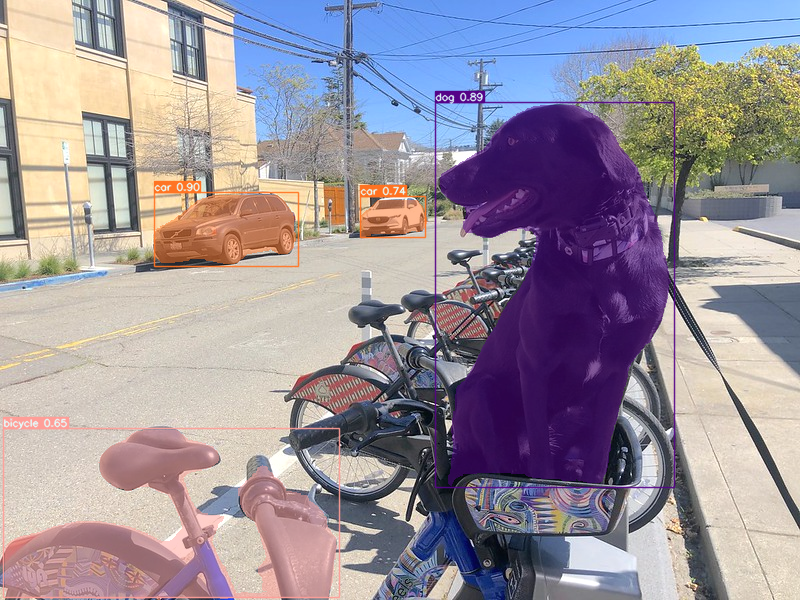

In [23]:
if device.value != "CPU":
    quantized_seg_model.reshape({0: [1, 3, 640, 640]})
quantized_seg_compiled_model = core.compile_model(quantized_seg_model, device.value)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_seg_compiled_model)[0]
image_with_masks = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_masks)

## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)


### Compare performance of the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2023.3/openvino_sample_benchmark_tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [24]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [25]:
!benchmark_app -m $seg_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.2.0-12690-0ee0b4d9561
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.2.0-12690-0ee0b4d9561
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 20.21 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [?,116,?]
[ INFO ]     output1 (node: output1) : f32 / [...] / [?,32,8..,8..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model

In [26]:
!benchmark_app -m $int8_model_seg_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.2.0-12690-0ee0b4d9561
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.2.0-12690-0ee0b4d9561
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 31.10 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,116,21..]
[ INFO ]     output1 (node: output1) : f32 / [...] / [1,32,8..,8..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Mo

### Validate quantized model accuracy
[back to top ⬆️](#Table-of-contents:)

As we can see, there is no significant difference between `INT8` and float model result in a single image test. To understand how quantization influences model prediction precision, we can compare model accuracy on a dataset.

In [27]:
int8_seg_stats = test(quantized_seg_model, core, seg_data_loader, seg_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/300 [00:00<?, ?it/s]

In [28]:
print("FP32 model accuracy")
print_stats(fp_seg_stats, seg_validator.seen, seg_validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_seg_stats, seg_validator.seen, seg_validator.nt_per_class.sum())

FP32 model accuracy
Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.609       0.524       0.579       0.416
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.602       0.501       0.557       0.354
INT8 model accuracy
Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.604       0.505        0.57       0.407
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.653       0.465       0.554       0.349


Great! Looks like accuracy was changed, but not significantly and it meets passing criteria.

## Other ways to optimize model
[back to top ⬆️](#Table-of-contents:)

The performance could be also improved by another OpenVINO method such as async inference pipeline or preprocessing API.

Async Inference pipeline help to utilize the device more optimal. The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to [Async API tutorial](../115-async-api/115-async-api.ipynb)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries. 
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will also improve selected device utilization. For more information, refer to the overview of [Preprocessing API tutorial](../118-optimize-preprocessing/118-optimize-preprocessing.ipynb). To see, how it could be used with YOLOV8 object detection model , please, see [Convert and Optimize YOLOv8 real-time object detection with OpenVINO tutorial](./230-yolov8-object-detection.ipynb)

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [29]:
import collections
import time
from IPython import display


def run_instance_segmentation(source=0, flip=False, use_popup=False, skip_first_frames=0, model=seg_model, device=device.value):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image[:, :, ::-1], compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Object Detection and Segmentation
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

In [30]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4'

In [31]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

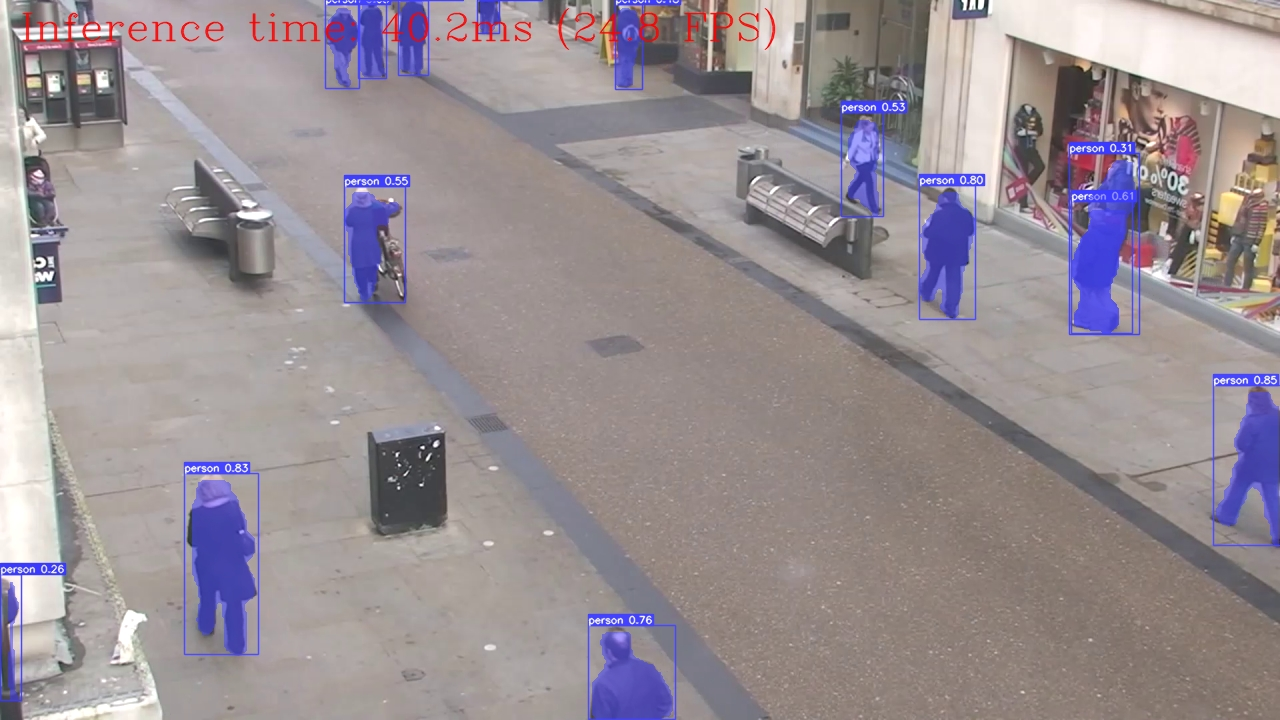

Source ended


In [32]:
run_instance_segmentation(source=VIDEO_SOURCE, flip=True, use_popup=False, model=seg_ov_model, device=device.value)